## Observations

In [73]:
using LinearAlgebra
using Plots
using ProfileView

In [ ]:
using Pkg
Pkg.add("BenchmarkTools")

# using BenchmarkTools
# @benchmark my_function(args)


In [74]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

In [75]:
function sample_random_matrix(xmin, xmax, d, n)
    matrix = zeros(d, n)
    for i in 1:d
        for j in 1:n
            matrix[i, j] = xmin + (xmax - xmin) * rand()
        end
    end
    return matrix
end

sample_random_matrix (generic function with 1 method)

In [76]:
BUDGET = 1

1

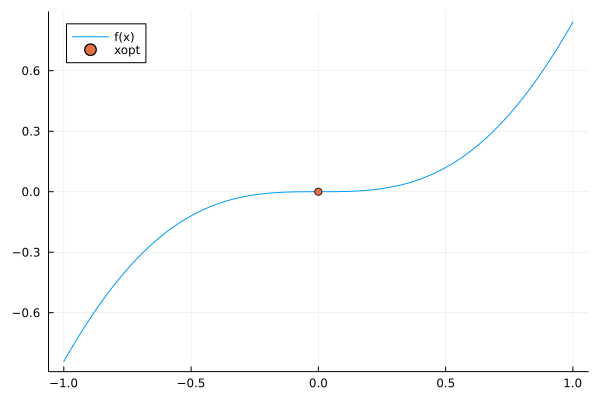

In [77]:
testfn = TestFunction(
    1,
    [-1. 1.],
    [0.],
    x -> (sin(first(x)) * first(x)^2),
    x -> [sin(first(x)) * 2first(x) + cos(first(x))*first(x)^2]
)
tplot(testfn)

In [171]:
n, h, σn2 = 1, 1, 1e-10
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

MAX_BUDGET, MAX_TRIALS = 25, 1
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [1.]
ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 64
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [ ]:
# X = [-6.5;; 0.;; 3.5;;]
X = [0.;;]
δX = rand(size(X)...)
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2)
domain = xmin:.01:xmax
domain = filter(x -> !(x in X), domain)
ex = zeros(length(domain))
stdx = zeros(length(domain))
dex = zeros(length(domain))
dstdx = zeros(length(domain))
αxs, ∇αxs = zeros(MC_SAMPLES), zeros(MC_SAMPLES)

for (i, x) in enumerate(domain)
    x0 = [x]

    # Rollout Trajectory
    for j in 1:MC_SAMPLES
        T = Trajectory(Base.deepcopy(sur), x0, h)
        rollout!(T, lbs, ubs; xstarts=xstarts, rnstream=lds_rns[j,:,:])
        αxs[j] = α(T)
        ∇αxs[j] = first(∇α(T))
    end

    sx = sur(x0)
    μ = sum(αxs) / MC_SAMPLES
    dμ = sum(∇αxs) / MC_SAMPLES
    ex[i] = μ + sx.EI
    dex[i] = dμ + first(sx.∇EI)
    stdx[i] = sqrt(sum((αxs .- μ) .^ 2) / (MC_SAMPLES - 1))
    dstdx[i] = sqrt(sum((∇αxs .- dμ) .^ 2) / (MC_SAMPLES - 1))
end

# ex = normalize(ex)
# dex = normalize(dex);

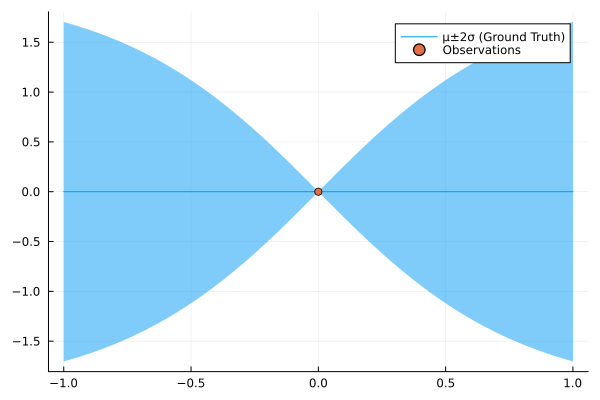

In [168]:
plot1D(sur; xmin=xmin, xmax=xmax, npts=1000)

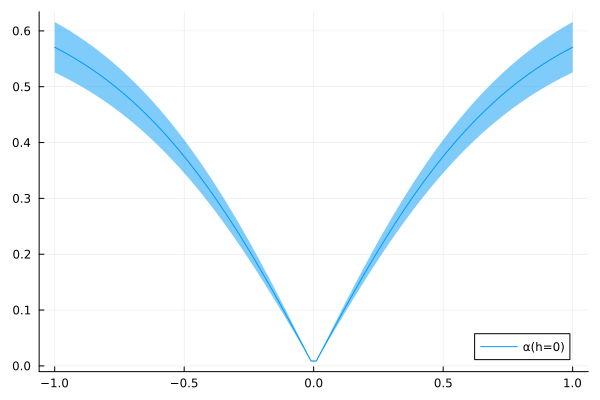

In [169]:
plot(domain, ex, ribbons=stdx / sqrt(MC_SAMPLES), label="α(h=$h)")
# plot!(domain, [sur([x]).EI for x in domain], label="EI")
# plot!(domain, dex, ribbons=dstdx / sqrt(MC_SAMPLES), label="∇α(h=$h)")

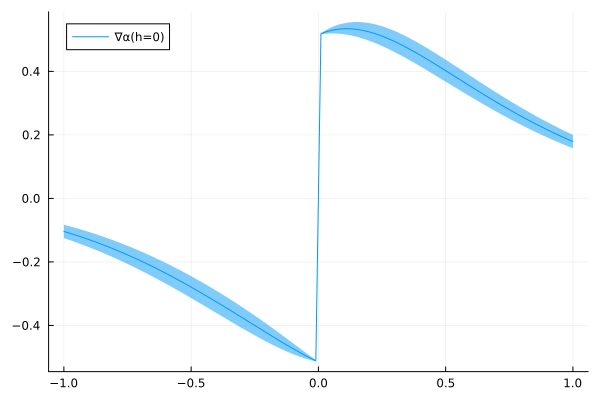

In [170]:
plot(domain, dex, ribbons=dstdx / sqrt(MC_SAMPLES), label="∇α(h=$h)")

In [160]:
function get_trajectory_path(T::Trajectory)
    @assert T.fs.fantasies_observed == T.fs.h + 1 "Trajectory isn't fully rolled out!"
    M = T.mfs.known_observed + 1
    sample_path = T.mfs.X[:, M:end]
    return sample_path
end

get_trajectory_path (generic function with 1 method)

In [ ]:
function visualize1D(T::Trajectory, lbs::Vector{Float64}, ubs::Vector{Float64})
    path = get_trajectory_path(T)[1, :]
    p = plot(
        0:T.h, path, color=:red, label=nothing, xlabel="Decision Epochs (h=$(T.h))",
        ylabel="Control Space (xʳ)", title="Trajectory Visualization in 1D",
        xticks=(0:T.h, ["x$(i)" for i in 0:T.h]), xrotation=45, grid=false
    )
    vline!(0:T.h, color=:black, linestyle=:dash, linewidth=1, label=nothing, alpha=.2)
    scatter!(0:T.h, path, color=:red, label=nothing)
    yticks!(
        round.(range(lbs[1], ubs[1], length=11), digits=1)
    )
    return p
end

function pvisualize1D(paths, lbs::Vector{Float64}, ubs::Vector{Float64})
    h = size(paths, 2)
    p = plot(
            0:h-1, paths[1, :], color=:red, label=nothing, xlabel="Decision Epochs (h=$(T.h))",
            ylabel="Control Space (xʳ)", title="Trajectory Visualization in 1D",
            xticks=(0:h, ["x$(i)" for i in 0:T.h]), xrotation=45, grid=false
        )
    vline!(p, 0:T.h, color=:black, linestyle=:dash, linewidth=1, label=nothing, alpha=.2)
    scatter!(p, 0:h-1, paths[1, :], color=:red, label=nothing)
    
    for i in 2:size(paths, 1)
        plot!(p, 0:h-1, paths[i, :], color=:red, label=nothing)
        scatter!(p, 0:h-1, paths[i, :], color=:red, label=nothing)
        yticks!(
            p, round.(range(lbs[1], ubs[1], length=11), digits=1)
        )
    end

    yticks!(
        p, round.(range(lbs[1], ubs[1], length=11), digits=1)
    )
        
    return p
end

In [ ]:
x0 = [8.]
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)

In [ ]:
x0 = [8.] .+ rand()
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)

In [ ]:
x0 = [-8.]
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)

In [ ]:
x0 = [-8.5]
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)